In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data = load_boston()
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [2]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
X, y = data["data"], data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([('std_scl',StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
# same leaking as we talked about previous in cross_validation
# remember though SVMs perform much better with scaled features

X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In [5]:
def plotCVResults(cv_res, names):
    fig = plt.figure(figsize=(20,10))
    trainin_time_ax = fig.add_subplot(2,1,2)
    for i in range(4):
        name = names[i]
        df_reg = pd.DataFrame(cv_res[i])

        ax = fig.add_subplot(2,4,i+1)

        ax.set_title(name + " scores, adj. avg test: " + \
                     str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
        ax.set_xlabel("iteration")
        ax.set_ylabel("R2 score")
        ax.set_ylim(0,1)
        df_reg[["train_score","test_score"]].plot(ax=ax)

        df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

    plt.sca(trainin_time_ax)
    plt.legend()
    plt.show()

In [9]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
cv_res = []
kernels = ['linear','poly','rbf','sigmoid']
C = 0.1
for kernel in kernels:
    cv_res.append(cross_validate(SVR(kernel=kernel,
                                     C=C), 
                            X_train,
                            y_train,
                            cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                            return_train_score = True,
                            return_estimator = True,
                            n_jobs = 2))

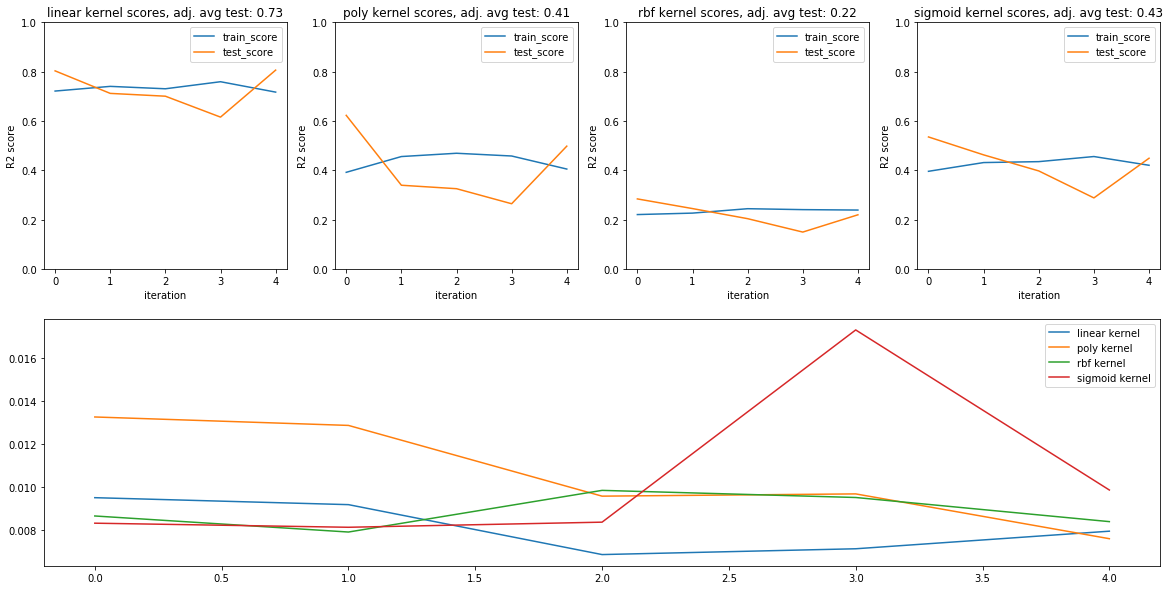

In [10]:
plotCVResults(cv_res, [str(x)+' kernel' for x in kernels])

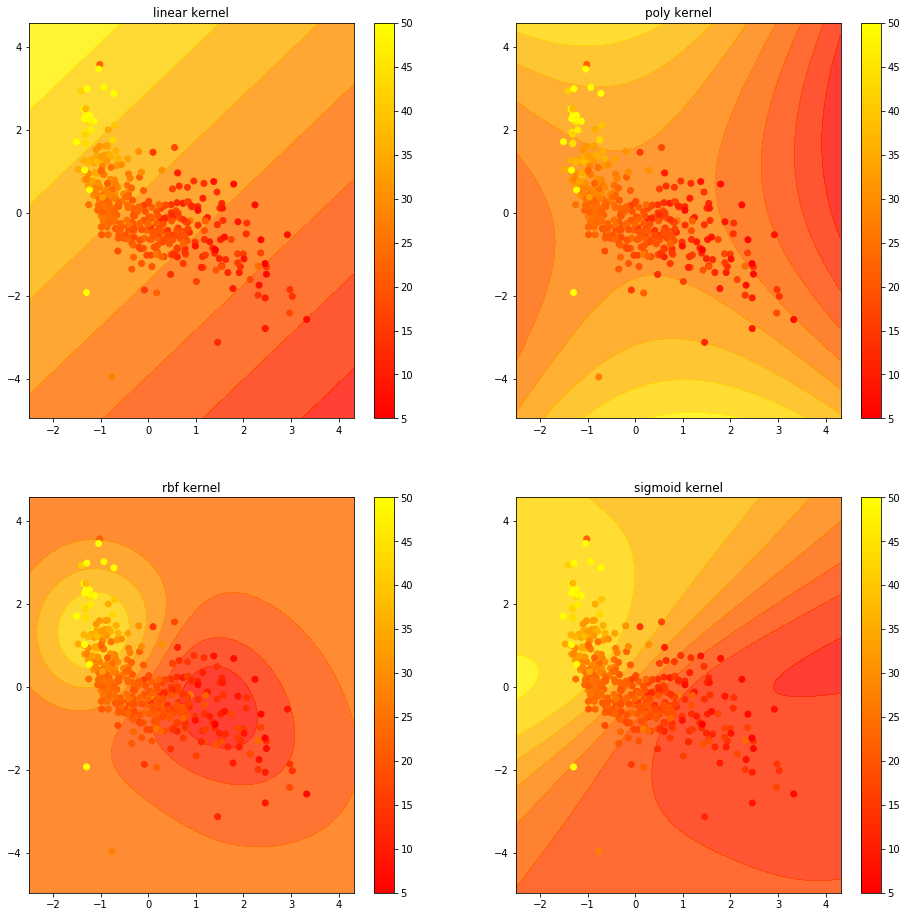

In [11]:
fig = plt.figure(figsize=(16,16))
for kernel in kernels:
    ax = fig.add_subplot(2,2,kernels.index(kernel)+1)
    svm_reg = SVR(kernel=kernel,degree=2, C=C) # regularization heavily impacts the fit here 
                                               # for sigmoid especially
    svm_reg.fit(X_train[['LSTAT','RM']],y_train['target'].ravel())
    h = .02
    x_min, x_max = X_train['LSTAT'].min() - 1, X_train['LSTAT'].max() + 1
    y_min, y_max = X_train['RM'].min() - 1, X_train['RM'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    xx_r = xx.ravel()
    yy_r = yy.ravel()
    Z = svm_reg.predict(np.c_[xx_r, yy_r])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.autumn, alpha=0.8)
    plt.scatter(X_train['LSTAT'],X_train['RM'],c=y_train['target'].ravel(), cmap=plt.cm.autumn)
    plt.colorbar()
    plt.title(kernel+' kernel')
plt.show()